# AOLME Datasets Generator

This is a fast CSV dataset generator from transcripts of AOLME Sessions in MS Word format.

We start with the import declarations:

In [1]:
import sys
import docx
import unidecode
import os

from datetime import datetime
from pandas import DataFrame
from utilities_nlp import load_roles, process_line

Next, the methods used to process the MS Word files and load roles:

In [2]:
students, co_facilitators, facilitators, non_role = load_roles()

Process Files Method

In [3]:
def process_files(file_name: str, dir_name: str):
    files = []
    if dir_name is not None and dir_name != '':
        file_names = os.listdir(dir_name)

        for sub_file_name in file_names:
            files.append(f'{dir_name}/{sub_file_name}')
    elif file_name is not None:
        files.append(file_name)
    else:
        print('Error: It is necessary to pass input file (-i) or input directory (-d)')
        sys.exit(2)

    data_frame = DataFrame([], columns=['Role', 'Text'])

    for file in files:
        document = docx.Document(docx=file)

        data_vector = []

        for line in document.paragraphs:
            line_text = line.text.replace('¿', '')
            line_text = unidecode.unidecode(line_text)
            role, text = process_line(line_text, students, co_facilitators, facilitators, non_role)

            if role is not None and text is not None:
                if text != '':
                    data_vector.append([role, text])

        data_frame = data_frame.append(DataFrame(data_vector, columns=['Role', 'Text']))

    return data_frame

## Loaded Roles.
Students:

In [4]:
print(students)

['Marissa', 'Benny', 'Brandon', 'Matias', 'Suzette']


Co-Facilitators:

In [5]:
print(co_facilitators)

['Judith', 'Brandon']


Facilitators:

In [6]:
print(facilitators)

['External Person', 'Isaac', 'Carlos', 'Man', 'Woman', 'Luis', 'Marios', 'Allan', 'External Person in [a-zA-Z_]']


## Files Processing

We are going to process all files stored in 'data' folder, to generate a Pandas DataFrame which will help us to search and filter rows, and finally to migrate the dataframe into a CSV file.

In [7]:
df = process_files(None, 'data')

students_count = len(df[df['Role'] == 'Student'])
facilitators_count = len(df[df['Role'] == 'Facilitator'])
co_facilitators_count = len(df[df['Role'] == 'Co-Facilitator'])

total = students_count + facilitators_count + co_facilitators_count

print(f'Students Count: {students_count} ({students_count * 100 / total:.2f}%)')
print(f'Facilitators Count: {facilitators_count} ({facilitators_count * 100 / total:.2f}%)')
print(f'CoFacilitators Count: {co_facilitators_count} ({co_facilitators_count * 100 / total:.2f}%)')
print(f'Total Rows: {total}')

# Define output filename
today = datetime.now()
d1 = today.strftime("%Y%m%d%H%M%S")
output_to = f'output/unbalanced_{d1}.csv'

df.to_csv(output_to, index=False)

output_filename = f'The CSV file has been created at {output_to}'
print('\n' + '#' * len(output_filename))
print(output_filename)

Students Count: 124 (21.53%)
Facilitators Count: 231 (40.10%)
CoFacilitators Count: 221 (38.37%)
Total Rows: 576

#####################################################################
The CSV file has been created at output/unbalanced_20201008235520.csv


We can see that the dataset has a different amount of rows for each role, as we can see in the following figure:

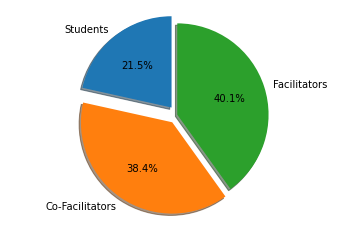

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
labels = 'Students', 'Co-Facilitators', 'Facilitators'
values = [students_count, co_facilitators_count, facilitators_count]
explode = (0.1, 0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

### Download Raw Unbalanced Dataset

In [9]:
from IPython.display import display, FileLink

local_file = FileLink(f'{output_to}', result_html_prefix="Click here to download: ")
display(local_file)

C:\Users\alexi\PycharmProjects\AolmeScripts\output\unbalanced_20201008235520.csv

## Prepare Balanced Dataset

The target of this module is creating a balanced dataset from the files, to allow the Deep Learning models to equally learn for each role:

In [10]:
sub_students = df.loc[df['Role'] == 'Student']
sub_co_facilitators = df.loc[df['Role'] == 'Co-Facilitator']
sub_facilitators = df.loc[df['Role'] == 'Facilitator']

if students_count < co_facilitators_count and students_count < facilitators_count:
    sub_co_facilitators = sub_co_facilitators.head(students_count)
    sub_facilitators = sub_facilitators.head(students_count)
elif co_facilitators_count < students_count and co_facilitators_count < facilitators_count:
    sub_students = sub_students.head(co_facilitators_count)
    sub_facilitators = sub_facilitators.head(co_facilitators_count)
else:
    sub_students = sub_students.head(facilitators_count)
    sub_co_facilitators = sub_co_facilitators.head(facilitators_count)

balanced_df = DataFrame(sub_students, columns=['Role', 'Text'])
balanced_df = balanced_df.append(sub_co_facilitators)
balanced_df = balanced_df.append(sub_facilitators)

students_count = len(balanced_df[balanced_df['Role'] == 'Student'])
facilitators_count = len(balanced_df[balanced_df['Role'] == 'Facilitator'])
co_facilitators_count = len(balanced_df[balanced_df['Role'] == 'Co-Facilitator'])

total = students_count + facilitators_count + co_facilitators_count

print(f'Students Count: {students_count} ({students_count * 100 / total:.2f}%)')
print(f'Facilitators Count: {facilitators_count} ({facilitators_count * 100 / total:.2f}%)')
print(f'CoFacilitators Count: {co_facilitators_count} ({co_facilitators_count * 100 / total:.2f}%)')
print(f'Total Rows: {total}')

output_to = f'output/balanced_{d1}.csv'

balanced_df.to_csv(output_to, index=False)

output_filename = f'The CSV file has been created at {output_to}'
print('\n' + '#' * len(output_filename))
print(output_filename)

Students Count: 124 (33.33%)
Facilitators Count: 124 (33.33%)
CoFacilitators Count: 124 (33.33%)
Total Rows: 372

###################################################################
The CSV file has been created at output/balanced_20201008235520.csv


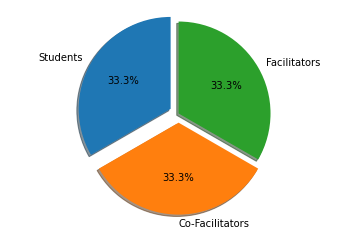

In [11]:
values = [students_count, co_facilitators_count, facilitators_count]
explode = (0.1, 0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

### Download Balanced Dataset

In [12]:
from IPython.display import display, FileLink

local_file = FileLink(f'{output_to}', result_html_prefix="Click here to download: ")
display(local_file)


C:\Users\alexi\PycharmProjects\AolmeScripts\output\balanced_20201008235520.csv